What is the point of this?

1) Prove that streaming in more data decreases MSE
- break down into separate functions that operate on ALS model for convertibility purposes
2) Convertable to Ralf.
- What is the structure of a Ralf experiment
- Source --> Passes down Record that has rating, movie, user
- BiasOperator --> Predicts, Updates Biases, passes down record that stores 

Predicting needs: biases, item vectors, user vectors
Bias Updating needs: user bias, item bias, error, learning rate, bias regularization terms
Factor Updating needs: error, learning rate, factor regularization terms, item vectors, user vectors

where can these vectors stay taht are stored and accessible across all? to ask in research meeting




In [13]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

In [14]:
# Download from Kaggle: https://www.kaggle.com/prajitdatta/movielens-100k-dataset
ratings_path = "/Users/amitnarang/Downloads/ml-100k/u.data"

In [15]:
columns=["user_id", "movie_id", "rating", "timestamp"]
df = pd.read_csv(ratings_path, sep = '\t', names=columns)

In [31]:
def split_train_test(df, num_test, num_users):
    columns = list(df.columns)
    train_data = []
    test_data = []
    for user_id in df["user_id"].unique():
        user_df = df[df["user_id"] == user_id].sort_values("timestamp")
        last_rows = user_df.tail(num_test)
        for row in user_df.itertuples():
            if row.user_id < num_users:
                data = [row.user_id, row.movie_id, row.rating, row.timestamp]
                if any(last_rows["movie_id"] == row.movie_id):
                    test_data.append(data)
                else:
                    train_data.append(data)
    train_df = pd.DataFrame(data=train_data, columns=columns).sample(frac=1)
    test_df = pd.DataFrame(data=test_data, columns=columns)
    return train_df, test_df

In [32]:
train_df, test_df = split_train_test(df, 5, 1000)
num_users = max(df['user_id'])
num_movies = max(df['movie_id'])

how to handle streaming sgd?

as we stream in a rating, update that movie's vector, that movie's bias, that user's vector, that user's bias

In [33]:
class ALSStreamingModel():
    
    def __init__(self, train_data, test_data, num_users, num_movies, num_features, learning_rate, user_bias_reg, movie_bias_reg, user_feature_reg, movie_feature_reg):
        self.train_data = train_data
        self.test_data = test_data
        self.num_users = num_users + 1
        self.num_movies = num_movies + 1
        self.learning_rate = learning_rate
        self.num_features = num_features
        
        self.global_bias = np.average(train_data['rating'])
        self.user_bias = np.zeros(self.num_users)
        self.movie_bias = np.zeros(self.num_movies)
        self.user_bias_reg = user_bias_reg
        self.movie_bias_reg = movie_bias_reg
        
        # make movie vectors initialiazble, global bias = avg(rating)
        self.user_vectors = np.random.normal(scale=1./self.num_features, size=(self.num_users, self.num_features))
        self.movie_vectors = np.random.normal(scale=1./self.num_features, size=(self.num_movies, self.num_features))
        self.user_feature_reg = user_feature_reg
        self.movie_feature_reg = movie_feature_reg
    
    def train(self):
        mse = []
        for row in self.train_data.itertuples():
            if row.Index % 10 == 0:
                mse.append(self.compute_test_mse())
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            error = self.compute_prediction_error(user_id, movie_id, rating)
            self.update_bias(user_id, movie_id, error)
            self.update_features(user_id, movie_id, error)
        self.test_mse_record = mse
            
    def update_bias(self, user_id, movie_id, error):
        self.user_bias[user_id] += self.learning_rate * (error - self.user_bias_reg * self.user_bias[user_id])
        self.movie_bias[movie_id] += self.learning_rate * (error - self.movie_bias_reg * self.movie_bias[movie_id])
    
    def update_features(self, user_id, movie_id, error):
        self.user_vectors[user_id, :] += self.learning_rate * (error * self.movie_vectors[movie_id, :] - self.user_feature_reg * self.user_vectors[user_id,:])
        self.movie_vectors[movie_id, :] += self.learning_rate * (error * self.user_vectors[user_id, :] - self.movie_feature_reg * self.movie_vectors[movie_id,:])
        
    def predict_rating(self, user_id, movie_id):
        biases = self.global_bias + self.user_bias[user_id] + self.movie_bias[movie_id]
        prediction = self.user_vectors[user_id].dot(self.movie_vectors[movie_id].T)
        return biases + prediction
    
    def compute_prediction_error(self, user_id, movie_id, rating):
        prediction = self.predict_rating(user_id, movie_id)
        return rating - prediction
    
    def compute_test_mse(self):
        predictions = []
        ratings = []
        for row in self.test_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            predictions.append(self.predict_rating(user_id, movie_id))
            ratings.append(rating) 
        mse = mean_squared_error(ratings, predictions)
        return mse
    
    def compute_train_mse(self):
        predictions = []
        ratings = []
        for row in self.train_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            predictions.append(self.predict_rating(user_id, movie_id))
            ratings.append(rating) 
        mse = mean_squared_error(ratings, predictions)
        return mse

In [19]:
als = ALSStreamingModel(train_df, test_df, num_users, num_movies, 40, .01, .1, .1, .1, .1)

In [20]:
curr_time = time.time()
als.train()
time_elapsed = time.time() - curr_time
print(time_elapsed)

0.9717528820037842


In [21]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

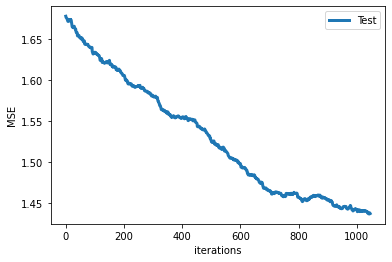

In [22]:
plot_learning_curve(als)

In [23]:
test_df

,user_id,movie_id,rating,timestamp
0,22,566,3,878888145
1,22,550,5,878888184
2,22,840,4,878888184
3,22,29,1,878888228
4,22,250,5,878888251
...,...,...,...,...
490,55,22,5,878176397
491,55,56,4,878176397
492,55,79,5,878176398
493,55,89,5,878176398


In [38]:
def generate_optimal_hyperparameters():
    learning_rates = [1e-3, 1e-2, 1e-1]
    user_bias_reg = [1e-2, 1e-1, 2e-1]
    movie_bias_reg = [1e-2, 1e-1, 2e-1]
    user_feature_reg = [1e-2, 1e-1, 2e-1]
    movie_feature_reg = [1e-2, 1e-1, 2e-1]

    best_params = {}
    best_params['learning_rate'] = None
    best_params['user_bias_reg'] = None
    best_params['movie_bias_reg'] = None
    best_params['user_feature_reg'] = None
    best_params['movie_feature_reg'] = None
    best_params['train_mse'] = np.inf
    best_params['test_mse'] = np.inf
    best_params['model'] = None


    for rate in learning_rates:
        print(rate)
        for ubreg in user_bias_reg:
            for mbreg in movie_bias_reg:
                for ufreg in user_feature_reg:
                    for mfreg in movie_feature_reg:
                        als = ALSStreamingModel(train_df, test_df, num_users, num_movies, 40, rate, ubreg, mbreg, ufreg, mfreg)
                        als.train()
                        test_mse = als.compute_test_mse()
                        if test_mse < best_params['test_mse']:
                            best_params['test_mse'] = test_mse
                            best_params['learning_rate'] = rate
                            best_params['train_mse'] = als.compute_train_mse()
                            best_params['user_bias_reg'] = ubreg
                            best_params['movie_bias_reg'] = mbreg
                            best_params['user_feature_reg'] = ufreg
                            best_params['movie_feature_reg'] = mfreg
                            best_params['model'] = als
                            print("New optimal parameters")
    return best_params

In [39]:
optimal_learning_rate = .1
optimal_ub_reg = .1
optimal_mb_reg = .01
optimal_uf_reg = .01
optimal_mf_reg = .1
train_df, test_df = train_df, test_df = split_train_test(df, 5, np.inf) 
als = ALSStreamingModel(train_df, test_df, num_users, num_movies, 50, optimal_learning_rate, optimal_ub_reg, optimal_mb_reg, optimal_uf_reg, optimal_mf_reg)
als.train()

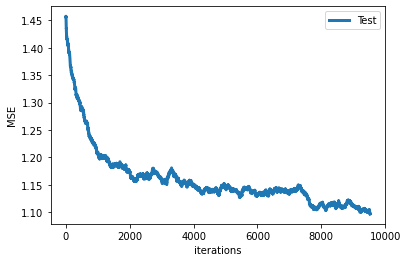

In [40]:
plot_learning_curve(als)

In [41]:
als.test_mse_record[-1]

1.0965690122469771